In [169]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [170]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [171]:
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

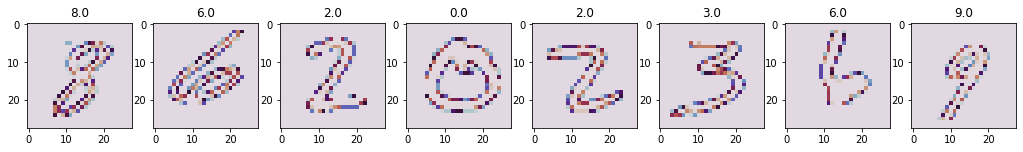

In [172]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[20:28], 1):
    subplot = fig.add_subplot(1, 9, i)
    plt.imshow(img, cmap='twilight');
    subplot.set_title('%s' % train_label[i + 19]);

## Используем метод k-средних

In [173]:
from sklearn.cluster import KMeans
KMeans = KMeans(n_clusters=10, random_state=0, n_init = 10)
train1 = train[:, 1:]
clusters = KMeans.fit_predict(train1)

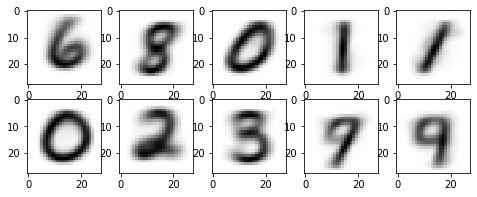

In [174]:
fig, ax = plt.subplots (2, 5, figsize = (8,3))
centres = KMeans.cluster_centers_.reshape(10, 28, 28)
for axi, center in zip(ax.flat, centres):
    axi.imshow(center, cmap=plt.cm.binary)

In [175]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters ==i)
    train2 = train[:, :1]
    labels[mask] = mode(train2[mask])[0][0]

In [176]:
from sklearn.metrics import accuracy_score
accuracy_score(train2, labels)

0.5908571428571429

## RandomForest


In [165]:
Xtrain, Xtest, ytrain, ytest = train_test_split(train1, train2,random_state=0)
model2 = RandomForestClassifier(n_estimators=1000)
model2.fit(Xtrain, ytrain)
ypred2 = model2.predict(Xtest)

C:\Users\seminaae\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [166]:
accuracy_score(ytest, ypred2)

0.9657142857142857

## Строим гистограммы градиентов

In [51]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [52]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

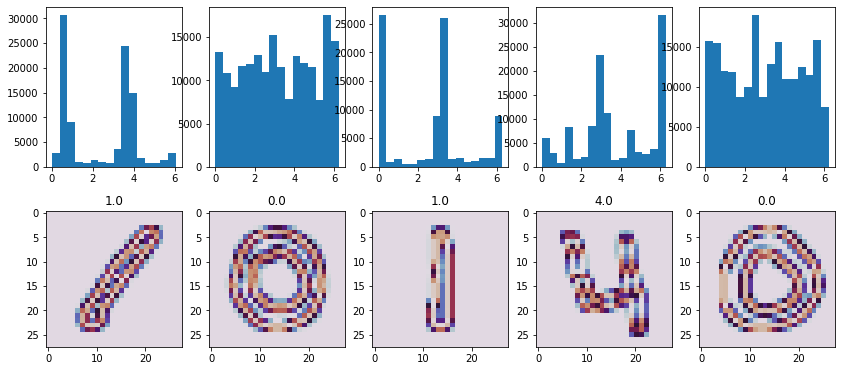

In [53]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='twilight');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

In [75]:
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [76]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [77]:
KMeans2 = KMeans(n_clusters=10, random_state=0, n_init = 10)
clusters = KMeans2.fit_predict(train_hist)

In [79]:
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters ==i)
    labels[mask] = mode(train2[mask])[0][0]

In [80]:
from sklearn.metrics import accuracy_score
accuracy_score(train2, labels)

0.32616666666666666

## Используем метод PCA и К-means

In [152]:
choices = np.random.choice(train_img.shape[0], 40000)

y = train_label[choices]
X = train_img[choices].reshape(-1, 28 * 28).astype(np.float32)
X_mean = X.mean(axis=0)
X -= X_mean
cov = np.dot(X.T, X) / X.shape[0]
U, S, _ = np.linalg.svd(cov)
U, S, _ = np.linalg.svd(cov)
S_cumsum = np.cumsum(S) / np.sum(S)


S_thr = 0.75  # задаем порог для накопленной суммы собственных значений
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))
Xrot_reduced = np.dot(X, U[:, :n_comp])
Xrot_restored = np.dot(Xrot_reduced, U[:,:n_comp].T)

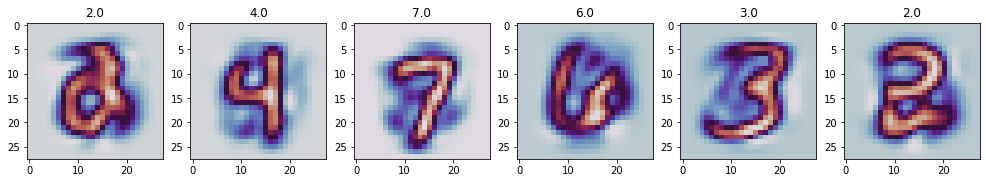

In [153]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(Xrot_restored[0:6], 1):
    subplot = fig.add_subplot(1, 7, i)
    img_ = img + X_mean
    plt.title('%s' % y[i-1])
    plt.imshow(img_.reshape((28,28)) + X_mean.reshape((28,28)), cmap='twilight');

In [137]:
from sklearn.cluster import KMeans

In [154]:
KMeans2 = KMeans(n_clusters=10, random_state=0, n_init = 10)
clusters3 = KMeans2.fit_predict(Xrot_restored)

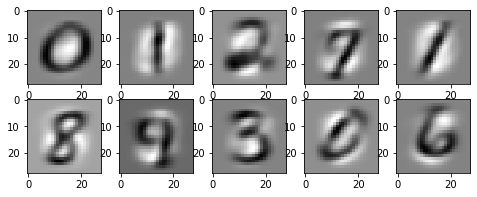

In [155]:
fig, ax = plt.subplots (2, 5, figsize = (8,3))
centres = KMeans2.cluster_centers_.reshape(10, 28, 28)
for axi, center in zip(ax.flat, centres):
    axi.imshow(center, cmap=plt.cm.binary)

In [156]:
labels = np.zeros_like(clusters3)
for i in range(10):
    mask = (clusters3 ==i)
    labels[mask] = mode(y[mask])[0][0]

In [157]:
accuracy_score(y, labels)

0.58535

## PCA и RandomForest

In [159]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(Xrot_restored, y,random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred1 = model.predict(Xtest)

In [161]:
accuracy_score(ytest, ypred1)

0.9799